<a href="https://colab.research.google.com/github/leonardoLavagna/Iscas2026/blob/main/notebooks/iscas_2026_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ISCAS 2026
**Notebook 1**

A unified framework Grover-quantum walks for NISQ attacks agains symmetric encryption-decryption schemes.

## Setup

In [ ]:
!git clone https://github.com/leonardoLavagna/Iscas2026

In [1]:
import os
os.chdir("Iscas2026")

In [ ]:
!pip install -r requirements.txt

## Grover search as quantum walk

In this part we establish the unified framework Grover $\Leftrightarrow$ quantum walks using the utilities in the cloned repository (i.e., `grover_walk.py`). We will work on two registers where the Grover diffusion gate or the Grover oracle can act as coin and shift operators of a suitable quantum walk.

In [2]:
from qiskit import transpile
from qiskit.visualization import plot_histogram
from utilities.grover_walk import *
from config import *

In [5]:
def run_walk_and_get_position_counts(n, marked_state, backend=None, shots=2048):
    """Runs the coined Grover-walk circuit and collects position register counts.

    Args:
        n (int): Number of qubits in coin and position registers (total 2n).
        marked_state (str): Bitstring of the marked state.
        backend (qiskit.providers.Backend, optional): Backend to run on.
        shots (int, optional): Number of measurement shots.

    Returns:
        tuple: (QuantumCircuit, dict) The circuit and position register counts.
    """
    qc = coined_grover_walk_search(n, marked_state)
    qct = transpile(qc, backend=backend)
    job = backend.run(qct, shots=shots)
    result = job.result()
    pos_counts = marginal_counts(result, indices=list(range(n, 2*n))).get_counts()
    return qc, pos_counts

Position register counts: {'0000': 46, '1000': 29, '1110': 41, '0001': 29, '1001': 37, '0110': 34, '1011': 45, '1101': 33, '0111': 49, '0100': 37, '0010': 27, '1100': 43, '0011': 25, '1010': 39, '0101': 481, '1111': 29}


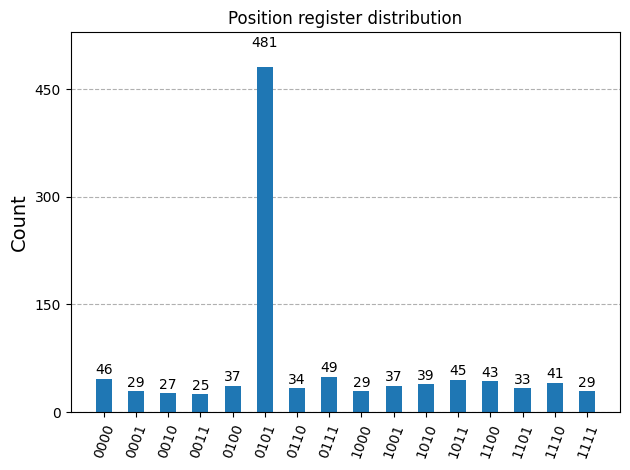

In [6]:
# Note: n>2
n = 4
marked_state = "0101"
qc, pos_counts = run_walk_and_get_position_counts(n, marked_state, backend=ideal_backend, shots=shots)
print("Position register counts:", pos_counts)
plot_histogram(pos_counts, title="Position register distribution")

As we can see, this unification works properly.

## Cesar's cipher

Here we focus on Caesar's cipher with the plaintext `THEQUICKBROWNFOXJUMPSOVERTHELAZYDOG` with associated ciphertext `YMJ VZNHPGWTBSKTCOZRUXTAJWYMJQFEDITL`. The main functions needed in this part are in the module `utilities.caesar_cipher_grover_compatible`.

## Quantum Walk-Grover attack against Cesar's cipher

In [3]:
from utilities.caesar_cipher_grover_compatible import *

In [8]:
def grover_walk_attack_caesar(ciphertext,
                              true_key= None,
                              crib_pair= None,
                              shots=shots,
                              backend=backend):
    """
    Grover (coined-walk) attack on Caesar's cipher key space.
    You must provide either:
      - true_key (for simulation), OR
      - crib_pair = (P, C) one aligned plaintext/ciphertext letter (A..Z).

    Args:
      - ciphertext (str): the ciphertext
      - true_key (int): the key of the symmetric encryption-decryption protocol
      - crib_pair (tuple(str)): a crib pair from which we can deduce the true_key
      - shots (int): number of measurement shots
      - backend (qiskit.providers.Backend): backend to run on

    Returns:
      dict: measured key distribution (over 26),
            best key, and decrypted text with that key.
    """
    if true_key is None and crib_pair is None:
        raise ValueError("Provide either true_key for simulation or crib_pair=(P,C).")
    # Derive key from crib pair
    if crib_pair is not None:
        P, C = crib_pair
        k = key_from_crib(P, C)
    # Derive the key from the input true key
    else:
        k = true_key % 26
    # Map key to 5-bit marked state
    n = 5
    marked_bits = int_to_bits(k, n)
    # Embeds key into n-qubit register and build coined grover walk
    qc = coined_grover_walk_search(n, marked_bits)
    tqc = transpile(qc, backend)
    job = backend.run(tqc, shots=shots)
    result = job.result()
    # Extracts distribution from position register
    # Position (= key) register is the last n qubits in our layout.
    pos_marg = marginal_counts(result, indices=list(range(n, 2*n))).get_counts()
    # Convert 5-bit outcomes to integers and aggregate only 0..25
    key_hist = {}
    for bitstr, cnt in pos_marg.items():
        key_int = int(bitstr, 2)
        if key_int < 26:
            key_hist[key_int] = key_hist.get(key_int, 0) + cnt
    # Pick best key
    best_key = max(key_hist, key=key_hist.get) if key_hist else None
    decrypted = caesar_decrypt(ciphertext, best_key) if best_key is not None else ""
    return {
        "key_hist_0_25": key_hist,
        "best_key": best_key,
        "decrypted_with_best": decrypted,
        "marked_key": k
    }

### Fault-tolerant case

A simple attack in an idealized regime with error correction, perfect gates and no noise.

In [9]:
ct = "YMJ VZNHP GWTBS KTC OZRUX TAJW YMJ QFED ITL"
# Suppose we know one aligned pair (crib): plaintext 'T' corresponds to ciphertext 'Y'
# (this is just for demo; any aligned pair works)
backend = ideal_backend
out = grover_walk_attack_caesar(ct, crib_pair=('T','Y'), shots=4096, backend=backend)
print("Marked (correct) key:", out["marked_key"])
print("Best key (Grover walk):", out["best_key"])
print("Decrypted:", out["decrypted_with_best"])

Marked (correct) key: 5
Best key (Grover walk): 5
Decrypted: THEQUICKBROWNFOXJUMPSOVERTHELAZYDOG


**Remark .** Resources needed
- One oracle call plus one diffusion (coin-shift) operation
- A Grover-type number of steps

thus resulting in $T=5\sim \sqrt{26}$ queries as expected.



### NISQ case

In [4]:
import matplotlib.pyplot as plt
from utilities.noise_level_and_topology import *

In [11]:
# Note: it can take a few minutes to run this cell
marked_key = 5
ks = list(range(1, 26))
ideal = []
noisy = []
for k in ks:
    ideal.append(success_prob_for_steps(marked_key, k, shots, ideal_backend))
    noisy.append(success_prob_for_steps(marked_key, k, shots, noisy_backend))

print("Steps:", ks)
print("Ideal success:", [round(x,3) for x in ideal])
print("Noisy success:", [round(x,3) for x in noisy])

Steps: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25]
Ideal success: [0.035, 0.26, 0.254, 0.596, 0.602, 0.903, 0.915, 1.0, 1.0, 0.867, 0.87, 0.557, 0.531, 0.218, 0.213, 0.017, 0.017, 0.046, 0.065, 0.302, 0.331, 0.674, 0.664, 0.924, 0.919]
Noisy success: [0.028, 0.232, 0.169, 0.497, 0.293, 0.672, 0.356, 0.672, 0.338, 0.586, 0.272, 0.435, 0.209, 0.213, 0.123, 0.138, 0.082, 0.153, 0.091, 0.245, 0.105, 0.319, 0.11, 0.414, 0.11]


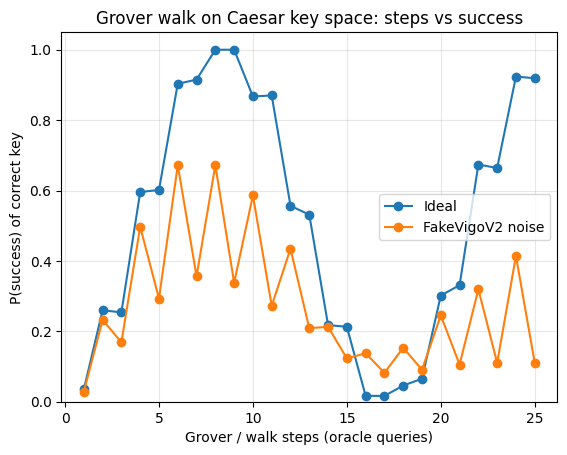

In [12]:
plt.figure()
plt.plot(ks, ideal, marker='o', label='Ideal')
plt.plot(ks, noisy, marker='o', label='FakeVigoV2 noise')
plt.xlabel("Grover / walk steps (oracle queries)")
plt.ylabel("P(success) of correct key")
plt.title("Grover walk on Caesar key space: steps vs success")
plt.ylim(0,1.05)
plt.grid(alpha=0.3)
plt.legend()
plt.show()

This is a standard Grover-like periodic behaviour where we can see that the noisy backend had an impact.

In [13]:
# Note: it can take a few minutes to run this cell
# we use 2*n with n=5 for the walk circuit
nq = 10
# 0=noiseless, 2x noise, etc.
scales = [0.0, 0.5, 1.0, 2.0]
base = dict(p1=1e-3, p2=8e-3, p_meas=2e-2)
for s in scales:
    be = make_backend_with_noise(nq, s*base['p1'], s*base['p2'], s*base['p_meas'])
    analyze_backend(be, f"dep+ro scale {s}", marked_key=5, shots=512)

[dep+ro scale 0.0] optimal steps = 8,  max success = 1.000
[dep+ro scale 0.0] first peak at k=6 with p=0.926
[dep+ro scale 0.0] second peak at k=8 with p=1.000
[dep+ro scale 0.0] estimated damping kappa ≈ nan

[dep+ro scale 0.5] optimal steps = 4,  max success = 0.332
[dep+ro scale 0.5] first peak at k=2 with p=0.201
[dep+ro scale 0.5] second peak at k=4 with p=0.332
[dep+ro scale 0.5] estimated damping kappa ≈ nan

[dep+ro scale 1.0] optimal steps = 6,  max success = 0.195
[dep+ro scale 1.0] first peak at k=2 with p=0.113
[dep+ro scale 1.0] second peak at k=4 with p=0.168
[dep+ro scale 1.0] estimated damping kappa ≈ nan

[dep+ro scale 2.0] optimal steps = 2,  max success = 0.086
[dep+ro scale 2.0] first peak at k=2 with p=0.086
[dep+ro scale 2.0] second peak at k=4 with p=0.072
[dep+ro scale 2.0] estimated damping kappa ≈ 11.54



We can go to higher scales (more shots and steps). Essentially what we can see even here is that:
- The damping estimator given needs the second peak lower than the first ($p_1<p_2$) and some second peak is equal or very close and the log term blows up. This is expected looking at Grover oscillation.
- Noise dampens amplitude (max success probability decreases fast).
- Noise shifts optimal step earlier (oracle queries fewer than ideal)
- For Caesar (tiny N=26), only a couple of walk steps are worth executing under noise

#### A combined experiment: noise level and topology

In [5]:
from qiskit.transpiler import CouplingMap

line_10 = CouplingMap.from_line(10)
noisy_line = make_backend_with_noise(10, 1e-3, 8e-3, 2e-2, coupling_map=line_10)

In [6]:
def run_grid(n=5,
             scales=(0.0, 0.5, 1.0, 2.0),
             base=dict(p1=1e-3, p2=8e-3, p_meas=2e-2),
             coupling_map=None,
             shots=1024,
             steps_range=range(1, 9)):
    """
    Sweep noise scales for a Grover-walk Caesar attack.
    Ensures nq=2*n qubits and applies an initial_layout to match the device map.
    """
    nq = 2 * n
    stats = []
    for s in scales:
        be = make_backend_with_noise(
            nq,
            s*base['p1'],
            s*base['p2'],
            s*base['p_meas'],
            coupling_map=coupling_map
        )
        # Use forced initial_layout inside analyze_backend
        xs, ys, peaks, kappa, k_opt, p_opt = analyze_backend(
            be,
            f"scale {s}",
            marked_key=5,
            steps_range=steps_range,
            shots=shots,
            N=26,
            topology = True,
            initial_layout=list(range(nq))
        )
        stats.append(dict(scale=s,
                          k_opt=k_opt,
                          p_opt=p_opt,
                          kappa=kappa))
    return stats

In [7]:
def plot_stats(stats, title):
    scales = [d['scale'] for d in stats]
    p_opts = [d['p_opt'] for d in stats]
    k_opts = [d['k_opt'] for d in stats]
    fig, ax1 = plt.subplots()
    color = 'tab:blue'
    ax1.set_xlabel("Noise scale")
    ax1.set_ylabel("Max success probability", color=color)
    ax1.plot(scales, p_opts, marker='o', color=color, label="Max success")
    ax1.tick_params(axis='y', labelcolor=color)
    ax1.set_ylim(0, 1.05)
    ax2 = ax1.twinx()
    color = 'tab:red'
    ax2.set_ylabel("Optimal steps", color=color)
    ax2.plot(scales, k_opts, marker='s', color=color, label="Optimal steps")
    ax2.tick_params(axis='y', labelcolor=color)
    plt.title(title)
    fig.tight_layout()
    plt.show()

In [8]:
# Note: it can take a few minutes to run this cell
dense_stats = run_grid(n=5)
print("Dense:", dense_stats)

[scale 0.0] optimal steps = 8,  max success = 1.000
[scale 0.0] first peak at k=6 with p=0.905
[scale 0.0] estimated damping kappa ≈ nan

[scale 0.5] optimal steps = 6,  max success = 0.380
[scale 0.5] first peak at k=4 with p=0.331
[scale 0.5] second peak at k=6 with p=0.380
[scale 0.5] estimated damping kappa ≈ nan

[scale 1.0] optimal steps = 6,  max success = 0.176
[scale 1.0] first peak at k=2 with p=0.155
[scale 1.0] second peak at k=4 with p=0.158
[scale 1.0] estimated damping kappa ≈ nan

[scale 2.0] optimal steps = 4,  max success = 0.072
[scale 2.0] first peak at k=2 with p=0.061
[scale 2.0] second peak at k=4 with p=0.072
[scale 2.0] estimated damping kappa ≈ nan

Dense: [{'scale': 0.0, 'k_opt': np.int64(8), 'p_opt': np.float64(1.0), 'kappa': nan}, {'scale': 0.5, 'k_opt': np.int64(6), 'p_opt': np.float64(0.3798828125), 'kappa': nan}, {'scale': 1.0, 'k_opt': np.int64(6), 'p_opt': np.float64(0.17578125), 'kappa': nan}, {'scale': 2.0, 'k_opt': np.int64(4), 'p_opt': np.float64(0

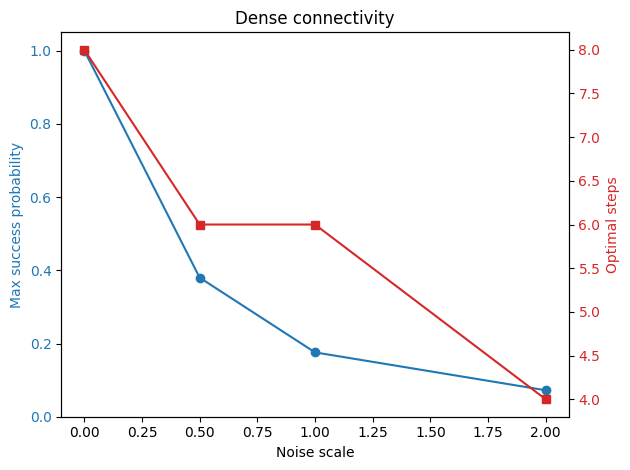

In [9]:
plot_stats(dense_stats, "Dense connectivity")

The point is: the noise level can be either "too much" or "too little" given the optimal number of steps (and a topology of qubit connectivity).

In the noiseless regime, the coined Grover walk achieves nearly unit success probability at the predicted number of steps. As we increase the depolarizing and readout noise rates, the amplification peak both lowers and shifts to earlier iterations. For Caesar’s 26-key space, the optimal number of oracle queries drops from 7-8 in the ideal case to only 2-3 under 2x realistic noise, with maximum success probability falling below 10%